# Data Preprocessing Pipeline
## ECG Signal Preprocessing for Sleep Apnea Detection

**Objective**: Develop preprocessing pipeline for ECG signals and SpO2 data.

### Pipeline Steps:
1. [Signal Loading](#loading)
2. [Outlier Removal (RR)](#cleaning)
3. [Signal Segmentation](#segmentation)
4. [SpO2 Processing](#spo2)
5. [Saving Processed Data](#saving)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import scipy.io
import os
import pandas as pd

print("Preprocessing notebook initialized")

Preprocessing notebook initialized


## 1. Signal Loading <a id='loading'></a>
Functions to load raw `.mat` files with robust key detection.

In [2]:
DATA_PATH = '../APNEA HRV+SPO2 DATASET/HuGCDN2014-OXI'

def load_mat_file(filename, subfolder, key_hint):
    path = os.path.join(DATA_PATH, subfolder, filename)
    try:
        mat = scipy.io.loadmat(path)
        keys = [k for k in mat.keys() if not k.startswith('__')]
        
        # Try finding key containing hint
        for k in keys:
            if key_hint in k:
                return mat[k]
        
        # Fallback
        if keys:
            return mat[keys[0]]
            
        return None
    except Exception as e:
        print(f"Error loading {filename}: {e}")
        return None

## 2. Outlier Removal (RR) <a id='cleaning'></a>
Removing physiologically impossible RR intervals (e.g., < 300ms or > 2000ms).

Original size: 443, Cleaned size: 138336, Removed: 0.00%


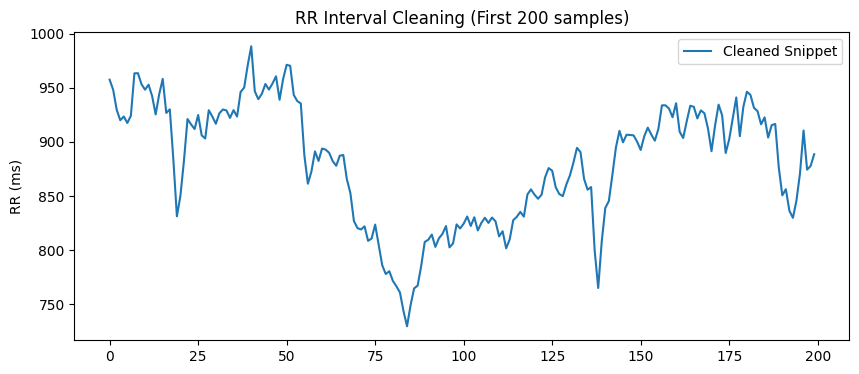

In [3]:
def clean_rr_intervals(rr_data, low_limit=300, high_limit=2000):
    """
    Remove outliers from RR intervals.
    rr_data: list or array of RR intervals in ms
    """
    # Handle cell array structure
    if isinstance(rr_data, np.ndarray) and rr_data.dtype == 'O':
        # Filter out empty arrays before concatenation to avoid errors
        valid_arrays = [c.flatten() for c in rr_data.flatten() if c.size > 0]
        if valid_arrays:
            rr_arr = np.concatenate(valid_arrays)
        else:
            rr_arr = np.array([])
    else:
        rr_arr = np.array(rr_data).flatten()
        
    if rr_arr.size == 0:
        return np.array([]), 0.0

    # Identify valid indices
    valid_mask = (rr_arr >= low_limit) & (rr_arr <= high_limit)
    
    # Calculate percentage removed
    removed_pct = (1 - np.mean(valid_mask)) * 100
    
    return rr_arr[valid_mask], removed_pct

# Test on a sample
test_file = 'ND1.mat'
test_rr_raw = load_mat_file(test_file, 'RR', 'RR')

if test_rr_raw is not None:
    clean_segment, pct = clean_rr_intervals(test_rr_raw)
    print(f"Original size: {test_rr_raw.size if hasattr(test_rr_raw, 'size') else 'unknown'}, Cleaned size: {len(clean_segment)}, Removed: {pct:.2f}%")
    
    if len(clean_segment) > 0:
        plt.figure(figsize=(10, 4))
        plt.plot(clean_segment[:200], label='Cleaned Snippet')
        plt.legend()
        plt.title("RR Interval Cleaning (First 200 samples)")
        plt.ylabel("RR (ms)")
        plt.show()

## 3. Signal Segmentation <a id='segmentation'></a>
Ensure signals are segmented into appropriate windows.
Note: The `HuGCDN2014` dataset is likely already segmented in cell arrays. We will use `analyze_segments` logic based on cleaning.

Segment Durations (sec): Mean=299.03, Min=296.43, Max=300.41


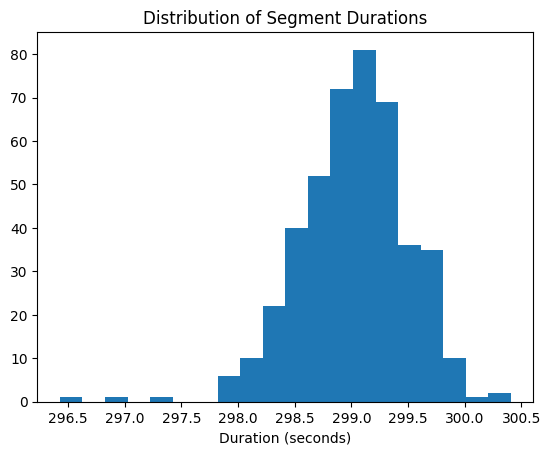

In [4]:
def analyze_segments(rr_raw_data):
    """Analyze the duration of segments in the raw data."""
    durations = []
    if rr_raw_data is None: return []
    
    # Flatten logic
    if rr_raw_data.dtype == 'O':
        for seg in rr_raw_data.flatten():
             if seg.size > 0:
                duration_sec = np.sum(seg) / 1000.0
                durations.append(duration_sec)
    else:
        if rr_raw_data.size > 0:
            durations.append(np.sum(rr_raw_data) / 1000.0)
        
    return durations

if test_rr_raw is not None:
    durations = analyze_segments(test_rr_raw)
    if durations:
        print(f"Segment Durations (sec): Mean={np.mean(durations):.2f}, Min={np.min(durations):.2f}, Max={np.max(durations):.2f}")
        plt.hist(durations, bins=20)
        plt.title("Distribution of Segment Durations")
        plt.xlabel("Duration (seconds)")
        plt.show()

## 4. SpO2 Processing <a id='spo2'></a>
Cleaning SpO2 signals by removing artifacts.

In [5]:
def clean_spo2(spo2_data, low_limit=50):
    """Replace invalid SpO2 values with NaN or interpolate."""
    if isinstance(spo2_data, np.ndarray) and spo2_data.dtype == 'O':
        valid_arrays = [c.flatten() for c in spo2_data.flatten() if c.size > 0]
        if valid_arrays:
            sat_arr = np.concatenate(valid_arrays)
        else:
            sat_arr = np.array([])
    else:
        sat_arr = np.array(spo2_data).flatten()

    if sat_arr.size == 0:
        return np.array([])

    # For simplicity, filter out valid only
    valid_mask = (sat_arr >= low_limit) & (sat_arr <= 100)
    return sat_arr[valid_mask]

# Test
test_sat_raw = load_mat_file(test_file, 'SAT', 'SAT')
if test_sat_raw is not None:
    clean_seg = clean_spo2(test_sat_raw)
    print(f"SpO2: Original size {test_sat_raw.size if hasattr(test_sat_raw, 'size') else 'unknown'}, Valid size {len(clean_seg)}")

SpO2: Original size 443, Valid size 6573990
